# Multivariate Time Series Forecasting Using LSTM:

In [38]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime

In [39]:
df=pd.read_csv('GE.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,6.009615,6.109776,5.949519,5.989583,1.009674,269568
1,1962-01-03,5.959535,5.959535,5.909455,5.929487,0.999544,184704
2,1962-01-04,5.929487,5.979567,5.809295,5.859375,0.987725,229632
3,1962-01-05,5.859375,5.869391,5.608974,5.709135,0.962398,340704
4,1962-01-08,5.709135,5.709135,5.528846,5.699119,0.960710,386880


In [40]:
df.shape

(15253, 7)

In [41]:
#Separate dates for future ploting
train_dates=pd.to_datetime(df['Date'])

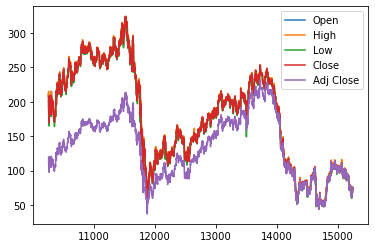

In [42]:
# variables for training
cols=list(df)[1:6]

df_for_training=df[cols].astype(float)
df_for_plot=df_for_training.tail(5000)

df_for_plot.plot.line();

In [43]:
#Normalize the dataset
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [44]:
# Reshaping the dataset for training purpose:
trainX=[]
trainY=[]

n_future=1 #No of days we want to predict in future
n_past=14 #No of past days we want to predict in future

for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future-1:i+n_future,0])
    
trainX,trainY=np.array(trainX),np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (15239, 14, 5).
trainY shape == (15239, 1).


In [45]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [46]:
# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
858/858 [==============================] - 39s 36ms/step - loss: 0.0506 - val_loss: 0.0046
Epoch 2/50
858/858 [==============================] - 31s 36ms/step - loss: 0.0331 - val_loss: 0.0028
Epoch 3/50
858/858 [==============================] - 32s 37ms/step - loss: 0.0334 - val_loss: 0.0033
Epoch 4/50
858/858 [==============================] - 30s 35ms/step - loss: 0.0314 - val_loss: 0.0031
Epoch 5/50
858/858 [==============================] - 33s 39ms/step - loss: 0.0310 - val_loss: 0.0025
Epoch 6/50
858/858 [==============================] - 30s 35ms/step - loss: 0.0320 - val_loss: 0.0024
Epoch 7/50
858/858 [==============================] - 30s 35ms/step - loss: 0.0312 - val_loss: 0.0016
Epoch 8/50
858/858 [==============================] - 31s 36ms/step - loss: 0.0322 - val_loss: 0.0018
Epoch 9/50
858/858 [==============================] - 32s 37ms/step - loss: 0.0291 - val_loss: 0.0019
Epoch 10/50
858/858 [==============================] - 36s 42ms/step - loss: 0.029

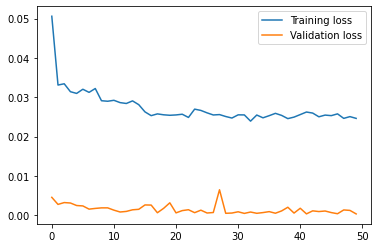

In [47]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [48]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-07-14 00:00:00', freq='C'), Timestamp('2022-07-15 00:00:00', freq='C'), Timestamp('2022-07-18 00:00:00', freq='C'), Timestamp('2022-07-19 00:00:00', freq='C'), Timestamp('2022-07-20 00:00:00', freq='C'), Timestamp('2022-07-21 00:00:00', freq='C'), Timestamp('2022-07-22 00:00:00', freq='C'), Timestamp('2022-07-25 00:00:00', freq='C'), Timestamp('2022-07-26 00:00:00', freq='C'), Timestamp('2022-07-27 00:00:00', freq='C'), Timestamp('2022-07-28 00:00:00', freq='C'), Timestamp('2022-07-29 00:00:00', freq='C'), Timestamp('2022-08-01 00:00:00', freq='C'), Timestamp('2022-08-02 00:00:00', freq='C'), Timestamp('2022-08-03 00:00:00', freq='C')]


In [49]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

1/1 [==============================] - 1s 968ms/step


C:\Users\Hp\AppData\Local\Temp/ipykernel_5712/3948340373.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

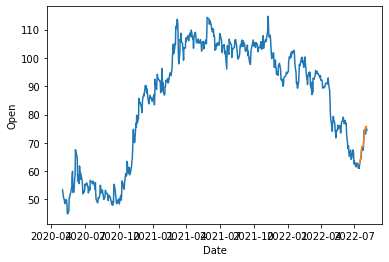

In [50]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open']);